## Expanding function to be used to expand theorems to help comprehension

In [475]:
import sys
sys.path.append("..")

from adapt_utils import replace_symbols

from tree_parser import *

import networkx as nx

#import matplotlib
#import matplotlib.pyplot as plt

import copy

import time

from my_utils import print_proof_props_graph, get_proof_steps, print_ident_proof, print_proof_linear_steps
from my_utils import get_proof_steps_graph, print_proof_steps_graph

import pickle

In [2]:
%%time

text = file_contents("../set.mm")
database = meta_math_database(text,n=3500)

included 5555695 tokens from ../set.mm
proposition: 3500CPU times: user 9.59 s, sys: 324 ms, total: 9.91 s
Wall time: 10.1 s


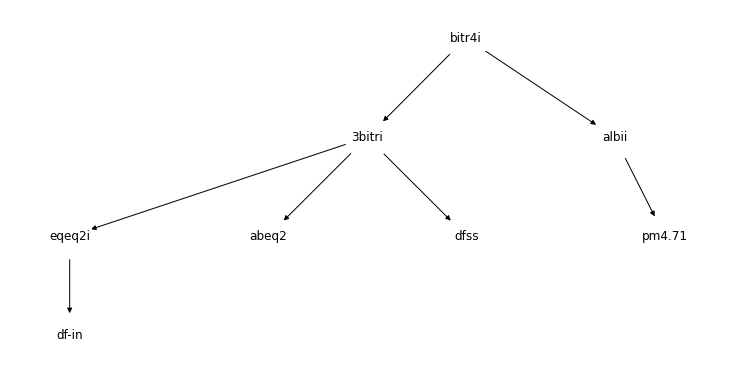

In [3]:
print_proof_props_graph("dfss2", database)

In [4]:
context_values = dict()

for prop in database.propositions_list:
    for k, v in prop.f.items():
        if k in context_values:
            if v.statement != context_values[k]:
                print(k, v.statement, context_values[k])
                break
        else:
            context_values[k] = v.statement

In [428]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

class Step:
    def __init__(self, name):
        self.name = name

def get_proof_graph_pn(pn, node_label="label"):
    G = nx.DiGraph()
    return _get_proof_graph_pn_recursive(pn, G, node_label), G

def _get_proof_graph_pn_recursive(pn, G, node_label="label"):
    if node_label == "label+statement":
        pn_gstep = Step(f"[{pn.label}] {pn.statement}")
    else:
        pn_gstep = Step(pn.label)
        
    for pni in pn.inputs:
        pni_gstep = _get_proof_graph_pn_recursive(pni, G, node_label)
        G.add_edge(pn_gstep, pni_gstep)
    return pn_gstep


def print_proof_props_graph_pn(pn, node_label="label"):
    
    root, G = get_proof_graph_pn(pn, node_label)

    graph_nodes = list(nx.dfs_preorder_nodes(G, root, 9))
    #print(len(graph_nodes))

    graph_nodes_labels = {n:n.name for n in graph_nodes}

    plt.figure(figsize=(10, 5))
    pos = graphviz_layout(G.subgraph(graph_nodes), prog="dot")#twopi
    nx.draw(G.subgraph(graph_nodes), pos, labels=graph_nodes_labels, node_color="w", node_size=2000)
    plt.show()

In [5]:
def eval_tree(tree):
    if tree.value in context_values: 
        return context_values[tree.value]
    
    prop = database.propositions[tree.value]
    assert len(tree.leaves)==len(prop.hyps)
    
    replacement_dict = {prop.hyps[i].variable: eval_tree(tree.leaves[i]) for i in range(len(prop.hyps)) if prop.hyps[i].type == "f"} #find the replacement rules for the variables
    #print 'replacement_dict', replacement_dict, 'applied to', prop.statement
    return string_replace(prop.statement[1:],replacement_dict)

def tree2str(tree):
    evaluated_tree = eval_tree(tree)
    return replace_symbols(" ".join(evaluated_tree))

def tree_to_string(tree, database, context):
    if tree.value in context.f: return context.f[tree.value].statement
    prop = database.propositions[tree.value]
    assert len(tree.leaves)==len(prop.hyps)
    replacement_dict = {prop.hyps[i].variable:tree_to_string(tree.leaves[i], database, context) for i in range(len(prop.hyps)) if prop.hyps[i].type == "f"} #find the replacement rules for the variables
    #print 'replacement_dict', replacement_dict, 'applied to', prop.statement
    return string_replace(prop.statement[1:],replacement_dict)

In [53]:
class PTree:
    def __init__(self, value, leaves):
        self._default_value = value
        self._default_leaves = leaves
        self._connected_ptree = None
        
    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return '<PTree: ' + self.stringify() + ' >'
    
    @property
    def value(self):
        if self._connected_ptree:
            return self._connected_ptree.value
        return self._default_value
    
    @property
    def leaves(self):
        if self._connected_ptree:
            return self._connected_ptree.leaves
        
        return self._default_leaves

    def stringify(self):
        if self.value is None: 
            return "???"  # for the beam search
        
        out = self.value + "("
        dontaddcomma = True
        for l in self.leaves:
            if not dontaddcomma: 
                out += ","
            else: 
                dontaddcomma = False
            out += l.stringify()
        out += ")"
        return out
    
    @property
    def statement(self):
        return tree2str(self)
            
    def connect(self, target_tree):
        ### Connect must be called from bottom up
        assert target_tree.value == self.value, f"{target_tree.value} {self.value}"
        assert len(target_tree.leaves) == len(self.leaves)
        
        #We can connect direct as the command below because other trees here are references by the symbols, 
        #not by the tree itself, since the arrangements of symbols are diferent.
        #self._connected_ptree = target_tree <- This doesnt work due that
        for this_leaf, target_leaf in zip(self.leaves, target_tree.leaves):
            this_leaf._connected_ptree = target_leaf
            
    def disconnect(self):
        for this_leaf in self.leaves:
            this_leaf._connected_ptree = None

In [54]:
def tree2ptree(tree, ph_dict={}):

    new_leaves = []
    for l in tree.leaves:
        if str(l) not in ph_dict:
            ph_dict[str(l)] = tree2ptree(l, ph_dict)
        new_leaves.append(ph_dict[str(l)])
    
    return PTree(tree.value, new_leaves)

In [55]:
prop = database.propositions["bitr4i"]
tree2ptree(prop.tree).statement

'( 𝜑 ↔ 𝜒 )'

In [82]:
def get_prop_hyps(prop):
    #We should use this function instead of direct checking for hypothesis
    #because if the prop is already a hypothesis, this property will not exist
    #which will raise an exception. This encapsulates and resolves this
    return prop.hyps if hasattr(prop, "hyps") else []

def get_step_replace_dict(step):
    
    repdict = {}
    
    #In case we are dealing with already hypotehsis nodes, there no hypothesis to work with
    #since there is no hypotehsis of a hypothesis, so we may skip it here
    #if hasattr(step.prop, "hyps"):
    
    e_hyps = [h for h in get_prop_hyps(step.prop) if h.type == 'e']
    assert len(e_hyps) == len(step._prior_entails), print(len(e_hyps), len(step._prior_entails))

    #Populate with hypothesis
    for raw_hyp, rep_hyp in zip(e_hyps, step._prior_entails):

        raw_tree = raw_hyp.tree
        rep_tree = rep_hyp.tree

        for pos in raw_tree.breadth_first_position_list():
            raw_subtree = raw_tree.tree_at_position(pos)
            rep_subtree = rep_tree.tree_at_position(pos)
            if raw_subtree.value != rep_subtree.value:
                repdict[raw_subtree.value] = rep_subtree

    
    
    #Populate with conclusion (this is necessary when there is no hypothesis)
    raw_tree = step.prop.tree
    rep_tree = step.tree
             
    for pos in raw_tree.breadth_first_position_list():
        raw_subtree = raw_tree.tree_at_position(pos)
        rep_subtree = rep_tree.tree_at_position(pos)
        if raw_subtree.value != rep_subtree.value:
            if raw_subtree.value in repdict and rep_subtree != repdict[raw_subtree.value]:
                print(rep_subtree, repdict[raw_subtree.value])
                raise Exception("Different trees within same node!")
            else:
                repdict[raw_subtree.value] = rep_subtree
        
    return repdict

In [230]:
class PNode:
    def __init__(self):
        self.depth = 0
        
        self.output = None
        self.inputs = []
        
        self._step = None

    
    @property
    def statement(self):
        return self.output_tree.statement
    
    def expand(self):
        #Return set of PNodes
        #Return the root PNode
        pass
    
    @classmethod
    def from_prop(cls, prop):
        ph_dict = {}
        
        new_pnode = PNode()
        new_pnode.prop = prop
        
        new_pnode.label = prop.label
        
        new_pnode._prop = prop
        new_pnode.output_tree = tree2ptree(prop.tree.copy(), ph_dict)
        new_pnode.input_trees = [tree2ptree(h.tree.copy(), ph_dict) for h in prop.hyps if h.type == 'e']
        
        return new_pnode
    
    @classmethod
    def from_step(cls, step):
        
        step_rd = get_step_replace_dict(step)
        ph_dict = {}
        
        new_pnode = PNode()
        new_pnode.prop = step.prop
        
        new_pnode.label = step.prop.label
        new_pnode.is_hyp = step.prop.type == 'e'
        new_pnode._step = step
        
        new_pnode.output_tree = tree2ptree(step.prop.tree.copy().replace(step_rd), ph_dict)
        new_pnode.input_trees = [tree2ptree(h.tree.copy().replace(step_rd), ph_dict) for h in get_prop_hyps(step.prop) if h.type == 'e']
        
        return new_pnode
    
    def __repr__(self):
        return f"<PNode: [{self.label}] ⊢ {self.statement} >"
        

In [231]:
prop0 = database.propositions["dfss2"]
pn0 = PNode.from_prop(prop0)

prop1 = database.propositions["bitr4i"]
pn1 = PNode.from_prop(prop1)

prop2 = database.propositions["3bitri"]
pn2 = PNode.from_prop(prop2)

prop3 = database.propositions["albii"]
pn3 = PNode.from_prop(prop3)

prop4 = database.propositions["pm4.71"]
pn4 = PNode.from_prop(prop4)

prop5 = database.propositions["dfss"]
pn5 = PNode.from_prop(prop5)

prop6 = database.propositions["eqeq2i"]
pn6 = PNode.from_prop(prop6)

prop7 = database.propositions["abeq2"]
pn7 = PNode.from_prop(prop7)

print(pn0.statement)
print(pn1.statement)
print(pn2.statement)
print(pn3.statement)
print(pn4.statement)
print(pn5.statement)
print(pn6.statement)
print(pn7.statement)

( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )
( 𝜑 ↔ 𝜒 )
( 𝜑 ↔ 𝜃 )
( ∀ x 𝜑 ↔ ∀ x 𝜓 )
( ( 𝜑 → 𝜓 ) ↔ ( 𝜑 ↔ ( 𝜑 ∧ 𝜓 ) ) )
( A ⊆ B ↔ A = ( A ∩ B ) )
( C = A ↔ C = B )
( A = { x | 𝜑 } ↔ ∀ x ( x ∈ A ↔ 𝜑 ) )


In [232]:
print(pn2.statement)
pn2.input_trees[0].connect(pn5.output_tree)
print(pn2.statement)

( 𝜑 ↔ 𝜃 )
( A ⊆ B ↔ 𝜃 )


In [233]:
prop0 = database.propositions["dfss2"]
pn0 = PNode.from_prop(prop0)
print(pn0.statement)
print()

for s in prop0.entails_proof_steps:
    step_pn = PNode.from_step(s)
    print(step_pn.label, step_pn.statement)

( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )

dfss ( A ⊆ B ↔ A = ( A ∩ B ) )
df-in ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }
eqeq2i ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )
abeq2 ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
3bitri ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
pm4.71 ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
albii ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
bitr4i ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )


In [443]:
def construct_proof_from_node(n):
    prop = n.prop
    root_step = prop.entails_proof_steps[-1]
    
    return construct_proof_from_raw_step(root_step)

    
def construct_proof_from_raw_step(raw_step):
    step_pn = PNode.from_step(raw_step)
    assert len(step_pn.input_trees) == len(raw_step._prior_entails) #Sanity check
    
    for input_t, child_raw_step in zip(step_pn.input_trees, raw_step._prior_entails):
        child_pn = construct_proof_from_raw_step(child_raw_step)
        input_t.connect(child_pn.output_tree)
        
        child_pn.output = step_pn
        step_pn.inputs.append(child_pn)
    
    return step_pn   



# def construct_proof(step_pn):
#     #step_pn = PNode.from_step(raw_step)
#     raw_step = step_pn._step
#     assert len(step_pn.input_trees) == len(raw_step._prior_entails)
#     for input_t, child_raw_step in zip(step_pn.input_trees, raw_step._prior_entails):
#         child_pn = construct_proof(PNode.from_step(child_raw_step))
#         input_t.connect(child_pn.output_tree)
        
#         child_pn.output = step_pn
#         step_pn.inputs.append(child_pn)
    
#     return step_pn

def get_proof_hyps(step, proof_hyps=None):
    #Perform a depth first collection of hypothesis from proof steps
    #Hopefully the order will match the original proposition hypothesis
    #This need to ensure that the hypothesis are not connected to anything
    
    if proof_hyps == None:
        proof_hyps = []
    
    if step.is_hyp and len(step.inputs) == 0:
        proof_hyps.append(step)
    else:
        for child_step in step.inputs:
            get_proof_hyps(child_step, proof_hyps)           
    return proof_hyps

def print_proof_steps_pn(step, ident=0):
    print("---" * ident, step)
    for cs in step.inputs:
        print_proof_steps_pn(cs, ident+1)


prop = database.propositions["dfss2"]
prop_pn = PNode.from_prop(prop)
print_proof_steps_pn(prop_pn)

 <PNode: [dfss2] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) ) >


In [444]:
prop_pn_proof = construct_proof_from_node(prop_pn)
print_proof_steps_pn(prop_pn_proof)

 <PNode: [bitr4i] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) ) >
--- <PNode: [3bitri] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
------ <PNode: [dfss] ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) ) >
------ <PNode: [eqeq2i] ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } ) >
--------- <PNode: [df-in] ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) } >
------ <PNode: [abeq2] ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
--- <PNode: [albii] ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
------ <PNode: [pm4.71] ⊢ ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >


In [445]:
def expand_pnode(pn):
    #1. Construct proof from step
    #2. Connect proof hyps with step hyps
    #3. Update input and output refs for every node
    
    #Step1
    pn_proof = construct_proof_from_node(pn)
    
    #Step2
    pn_hyps = pn.inputs 
    pn_proof_hyps = get_proof_hyps(pn_proof)
    
    assert len(pn_hyps) == len(pn_proof_hyps), f"{pn_hyps} {pn_proof_hyps}" #Sanity Check
    for pn_hyp, pn_proof_hyp in zip(pn_hyps, pn_proof_hyps):
        pn_proof_hyp_input_index = pn_proof_hyp.output.inputs.index(pn_proof_hyp)
        pn_proof_hyp.output.input_trees[pn_proof_hyp_input_index].connect(pn_hyp.output_tree)
        
        #Step3 (Partially) for hyps
        pn_proof_hyp.output.inputs[pn_proof_hyp_input_index] = pn_hyp
        pn_hyp.output = pn_proof_hyp.output
        
    #Step3 For root node
    if pn.output != None: #In case this node is not the root step
        pn_proof.output = pn.output
        pn_output_index = pn.output.inputs.index(pn) #This must always exists
        assert pn_output_index >= 0
        pn.output.inputs[pn_output_index] = pn_proof
        
#     for pn_hyp, pn_proof_hyp in zip(pn_hyps, pn_proof_hyps):
#         assert len(pn_proof_hyp.inputs) == 0 #Sanity check, the fresh hyps should contain no input
#         #By definition hypothesis inputs can be larger than one, so this looks fine
#         pn_proof_hyp.inputs = [pn_hyp]
        
#         for inp in pn_hyp.inputs:
#             inp.output = pn_proof_hyp
            
    return pn_proof

def get_root_node(pn):
    if pn.output == None:
        return pn
    return get_root_node(pn.output)

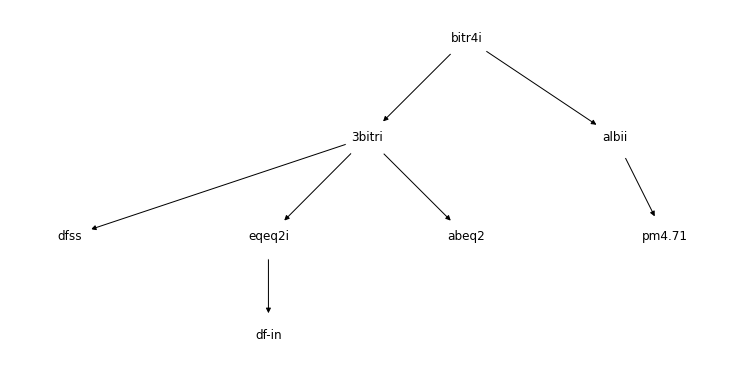

In [446]:
print_proof_props_graph_pn(prop_pn_proof)

In [447]:
prop_pn_proof_exp = expand_pnode(prop_pn_proof)

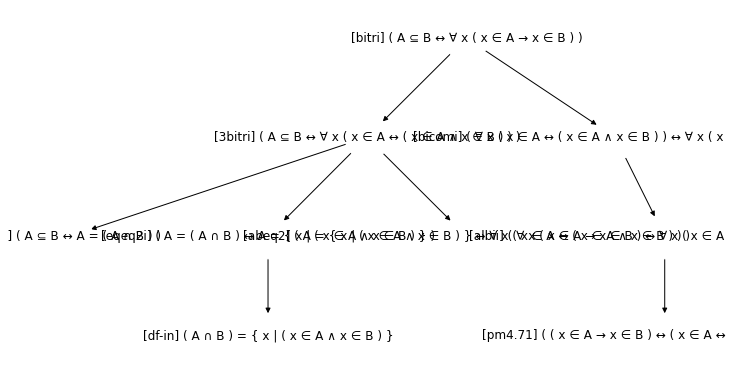

In [448]:
print_proof_props_graph_pn(prop_pn_proof_exp, "label+statement")

In [449]:
prop_pn_proof_exp3 = expand_pnode(prop_pn_proof_exp.inputs[0])

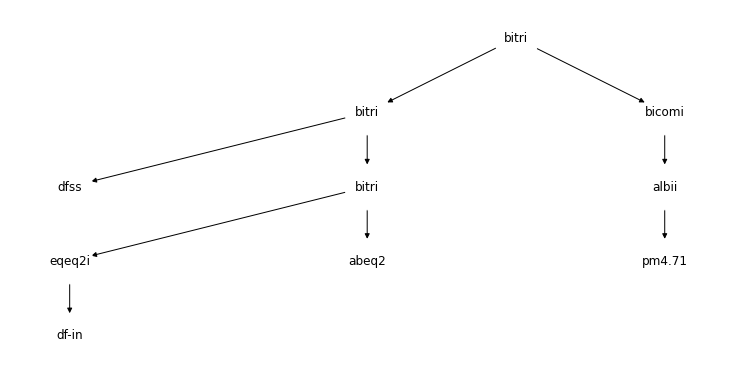

In [450]:
print_proof_props_graph_pn(get_root_node(prop_pn_proof_exp3))

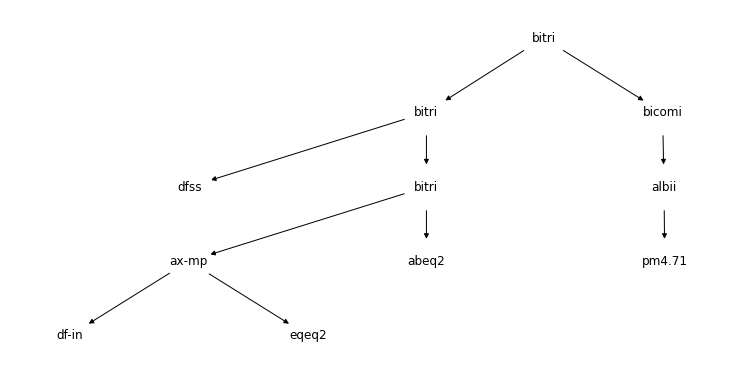

In [451]:
prop_pn_proof_exp4 = expand_pnode(prop_pn_proof_exp3.inputs[1].inputs[0])
print_proof_props_graph_pn(get_root_node(prop_pn_proof_exp4))

In [452]:
print_proof_steps_pn(get_root_node(prop_pn_proof_exp4))

 <PNode: [bitri] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) ) >
--- <PNode: [bitri] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
------ <PNode: [dfss] ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) ) >
------ <PNode: [bitri] ⊢ ( A = ( A ∩ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
--------- <PNode: [ax-mp] ⊢ ( C = ( A ∩ B ) ↔ C = { x | ( x ∈ A ∧ x ∈ B ) } ) >
------------ <PNode: [df-in] ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) } >
------------ <PNode: [eqeq2] ⊢ ( A = B → ( C = A ↔ C = B ) ) >
--------- <PNode: [abeq2] ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
--- <PNode: [bicomi] ⊢ ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) ) >
------ <PNode: [albii] ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
--------- <PNode: [pm4.71] ⊢ ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >


The problem with ax-mp may be solvable by using the previous idea of propagate context, although the previous appraoch failled with dfss3


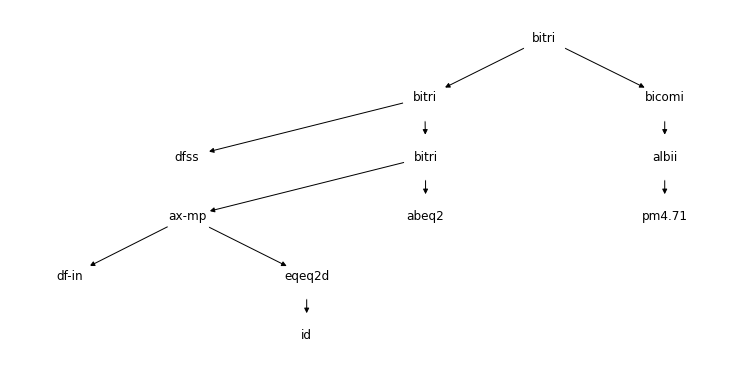

In [424]:
prop_pn_proof_exp5 = expand_pnode(prop_pn_proof_exp4.inputs[1])
print_proof_props_graph_pn(get_root_node(prop_pn_proof_exp5))

In [430]:
print_proof_steps_pn(get_root_node(prop_pn_proof_exp5))

 <PNode: [bitri] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) ) >
--- <PNode: [bitri] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
------ <PNode: [dfss] ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) ) >
------ <PNode: [bitri] ⊢ ( A = ( A ∩ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
--------- <PNode: [ax-mp] ⊢ ( C = ( A ∩ B ) ↔ C = { x | ( x ∈ A ∧ x ∈ B ) } ) >
------------ <PNode: [df-in] ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) } >
------------ <PNode: [eqeq2d] ⊢ ( A = B → ( C = A ↔ C = B ) ) >
--------------- <PNode: [id] ⊢ ( A = B → A = B ) >
--------- <PNode: [abeq2] ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
--- <PNode: [bicomi] ⊢ ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) ) >
------ <PNode: [albii] ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >
--------- <PNode: [pm4.71] ⊢ ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >


In [440]:
axmp = get_root_node(prop_pn_proof_exp5).inputs[0].inputs[1].inputs[0]
axmp

<PNode: [ax-mp] ⊢ ( C = ( A ∩ B ) ↔ C = { x | ( x ∈ A ∧ x ∈ B ) } ) >

In [441]:
axmp.inputs

[<PNode: [df-in] ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) } >,
 <PNode: [eqeq2d] ⊢ ( A = B → ( C = A ↔ C = B ) ) >]

In [374]:
pn_proof123 = construct_proof_from_node(prop_pn_proof_exp)

In [375]:
pn_proof123.inputs[1].inputs[1].inputs

[]

In [376]:
get_proof_hyps(pn_proof123)

[<PNode: [bitri.1] ⊢ ( 𝜑 ↔ 𝜓 ) >,
 <PNode: [bitri.2] ⊢ ( 𝜓 ↔ 𝜒 ) >,
 <PNode: [bitri.1] ⊢ ( 𝜑 ↔ 𝜓 ) >,
 <PNode: [bitri.2] ⊢ ( 𝜓 ↔ 𝜒 ) >]

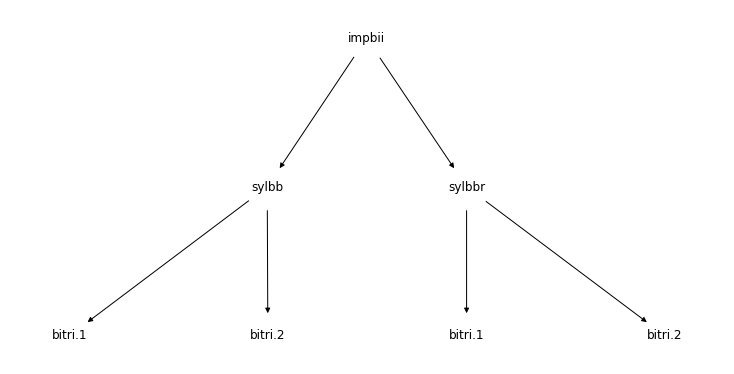

In [377]:
print_proof_props_graph_pn(pn_proof123)

In [378]:
prop_pn_proof_exp2 = expand_pnode(prop_pn_proof_exp)

AssertionError: [<PNode: [3bitri] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >, <PNode: [bicomi] ⊢ ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) ) >] [<PNode: [bitri.1] ⊢ ( 𝜑 ↔ 𝜓 ) >, <PNode: [bitri.2] ⊢ ( 𝜓 ↔ 𝜒 ) >, <PNode: [bitri.1] ⊢ ( 𝜑 ↔ 𝜓 ) >, <PNode: [bitri.2] ⊢ ( 𝜓 ↔ 𝜒 ) >]

In [168]:
root_step_pn

<PNode: [bitr4i] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) ) >

In [169]:
root_step1 = database.propositions["bitr4i"].entails_proof_steps[-1]
root_step_pn1 = construct_proof(root_step1)

In [176]:
get_proof_hyps(root_step_pn)

[<PNode: [bitr4i.1] ⊢ ( 𝜑 ↔ 𝜓 ) >, <PNode: [bitr4i.2] ⊢ ( 𝜒 ↔ 𝜓 ) >]

In [154]:
print(root_step_pn1)
print(root_step_pn1.inputs)
root_step_pn1.input_trees

<PNode: [bitri] ⊢ ( 𝜑 ↔ 𝜒 ) >
[<PNode: [bitr4i.1] ⊢ ( 𝜑 ↔ 𝜓 ) >, <PNode: [bicomi] ⊢ ( 𝜓 ↔ 𝜒 ) >]


[<PTree: wb(wph(),wps()) >, <PTree: wb(wps(),wch()) >]

In [156]:
root_step_pn1.input_trees[0].connect(root_step_pn.inputs[0].output_tree)
print(root_step_pn1)
print(root_step_pn1.inputs)

<PNode: [bitri] ⊢ ( A ⊆ B ↔ 𝜒 ) >
[<PNode: [bitr4i.1] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >, <PNode: [bicomi] ⊢ ( 𝜓 ↔ 𝜒 ) >]


In [155]:
root_step_pn1.inputs[0].output_tree.connect(root_step_pn.inputs[0].output_tree)
print(root_step_pn1)
print(root_step_pn1.inputs)

<PNode: [bitri] ⊢ ( A ⊆ B ↔ 𝜒 ) >
[<PNode: [bitr4i.1] ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) >, <PNode: [bicomi] ⊢ ( 𝜓 ↔ 𝜒 ) >]


In [137]:
print(root_step_pn1)
print(root_step_pn1.inputs)
root_step_pn1.input_trees

<PProp: [bitri] ⊢ ( A ⊆ B ↔ 𝜒 ) >
[<PProp: [bitr4i.1] ⊢ ( 𝜑 ↔ 𝜓 ) >, <PProp: [bicomi] ⊢ ( 𝜓 ↔ 𝜒 ) >]


[<PTree: wb(wss(cA(),cB()),wal(wb(wcel(cv(vx()),cA()),wa(wcel(cv(vx()),cA()),wcel(cv(vx()),cB()))),vx())) >,
 <PTree: wb(wal(wb(wcel(cv(vx()),cA()),wa(wcel(cv(vx()),cA()),wcel(cv(vx()),cB()))),vx()),wch()) >]

In [121]:
root_step_pn1.input_trees[0].connect(root_step_pn.inputs[0].output_tree)

In [119]:
root_step_pn1.inputs[1].input_trees[0].connect(root_step_pn.inputs[1].output_tree)

In [6]:
#1. Olhar pro passo
#2. Pegar as variaveis F do teorema correspondente ao passo
#3. Preencher dentro dos passos dentro da prova do teorema

In [17]:
def populate_post_entails(step):
    #Get all steps. This is necessary because hypothesis are not natively within entails proof_steps
    all_steps = []
    for pstep in step.entails_proof_steps:
        if pstep not in all_steps:
            all_steps.append(pstep)

        for prior_pstep in pstep._prior_entails:
            if prior_pstep not in all_steps:
                all_steps.append(prior_pstep)

    for child_step in all_steps:
        child_step._post_entail = None
        
    for child_step in all_steps:
        for gchild_step in child_step._prior_entails:
            gchild_step._post_entail = child_step

In [472]:
context_values

{'wph': ['ph'],
 'wps': ['ps'],
 'wch': ['ch'],
 'wth': ['th'],
 'wta': ['ta'],
 'wet': ['et'],
 'wze': ['ze'],
 'wsi': ['si'],
 'wrh': ['rh'],
 'wmu': ['mu'],
 'wla': ['la'],
 'wka': ['ka'],
 'vx.wal': ['x'],
 'vx.cv': ['x'],
 'cA.wceq': ['A'],
 'cB.wceq': ['B'],
 'vx.tru': ['x'],
 'vy.tru': ['y'],
 'vx': ['x'],
 'vy': ['y'],
 'vz': ['z'],
 'vw': ['w'],
 'vt': ['t'],
 'vu': ['u'],
 'vv': ['v'],
 'v.vs': ['s'],
 'wcel.cA': ['A'],
 'wcel.cB': ['B'],
 'cbvex4v.vf': ['f'],
 'cbvex4v.vg': ['g'],
 'cA': ['A'],
 'cB': ['B'],
 'cC': ['C'],
 'cD': ['D'],
 'cF': ['F'],
 'cG': ['G'],
 'cE': ['E'],
 'cV': ['V'],
 'cR': ['R'],
 'cS': ['S'],
 'cW': ['W'],
 'cH': ['H'],
 'vs': ['s'],
 'cX': ['X'],
 'cT': ['T'],
 'cQ': ['Q'],
 'cY': ['Y'],
 'va': ['a']}

In [476]:
prop = database.propositions["dfss2"]

#root_step = prop.entails_proof_steps[-1]

for exp_step in prop.entails_proof_steps:
    print("--- [{}]".format(exp_step.prop.label), len(exp_step._prior_entails), "|-", replace_symbols(exp_step.tree.eval(database, root_step.context)))

print()

root_step = prop.entails_proof_steps[-1]
exp_proof = expand_proof_step(root_step)

print("[{}]".format(root_step.prop.label), "|-", replace_symbols(root_step.tree.eval(database, root_step.context)))

for exp_step in exp_proof:
    print("--- [{}]".format(exp_step.prop.label), "|-", replace_symbols(exp_step.tree.eval(database, root_step.context)))

--- [dfss] 0 |- ( A ⊆ B ↔ A = ( A ∩ B ) )
--- [df-in] 0 |- ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }
--- [eqeq2i] 1 |- ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )
--- [abeq2] 0 |- ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
--- [3bitri] 3 |- ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
--- [pm4.71] 0 |- ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
--- [albii] 1 |- ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
--- [bitr4i] 2 |- ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )

[bitr4i] |- ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )
--- [bicomi] |- ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) )
--- [bitri] |- ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )


In [477]:
root_step = exp_proof[0]

exp_proof = expand_proof_step(root_step)

print("[{}]".format(root_step.prop.label), "|-", replace_symbols(root_step.tree.eval(database, root_step.context)))
print()

for exp_step in exp_proof:
    print("--- [{}]".format(exp_step.prop.label), "|-", replace_symbols(exp_step.tree.eval(database, root_step.context)))

[bicomi] |- ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) )

--- [bicom1] |- ( ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) → ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) ) )
--- [ax-mp] |- ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) )


In [28]:
step_rep_dict = get_step_replace_dict(root_step)
step_rep_dict

{'wps': <Tree: wal(wb(wcel(cv(vx()),cA()),wa(wcel(cv(vx()),cA()),wcel(cv(vx()),cB()))),vx())>,
 'wch': <Tree: wal(wi(wcel(cv(vx()),cA()),wcel(cv(vx()),cB())),vx())>}

### Defining Classes

In [454]:
def expand_proof_step(root_step):
    
    expanded_steps = []
    
    if not hasattr(root_step, "replace_dict_list"):
        root_step.replace_dict_list = [get_step_replace_dict(root_step)]
        
    step2exp = dict() #Store references from steps to expanded steps to populate 
    
    for child_step in root_step.prop.entails_proof_steps:
        #Take the original prop tree
        exp_tree = child_step.prop.tree.copy()
        
        #Take the step transformation that was used to the raw step to the replace step
        replace_dict_list = [get_step_replace_dict(child_step)]
            
        #Get the root step replace dicts so we can iterativelly expand the steps
        replace_dict_list.extend(root_step.replace_dict_list)
        
        for rep_dict in replace_dict_list:
            exp_tree = exp_tree.replace(rep_dict)
        
        prior_statements = child_step.prior_statements if hasattr(child_step, "prior_statements") else []
        
        exp_step = proof_step(exp_tree, root_step.context, child_step.prop, prior_statements)
        exp_step.replace_dict_list = replace_dict_list
        
        expanded_steps.append(exp_step)
        
        step2exp[child_step] = exp_step
        
    #Populate _prior_entails
    for child_step in root_step.prop.entails_proof_steps:
        step2exp[child_step]._prior_entails = [step2exp.get(cc, cc) for cc in child_step._prior_entails]
    
        
    return expanded_steps

In [34]:
class ExpProof:
    
    def __init__(self, prop):
        self._prop = prop
        self.steps = {}
        self._next_id = 0
        
        #Populate child entails for every step
        populate_post_entails(prop)
        
        step2exp = dict() #Dictionary to store references from steps to expandable steps
        
        #Get all steps. This is necessary because hypothesis are not natively within entails proof_steps
        all_steps = []
        for pstep in prop.entails_proof_steps:
            if pstep not in all_steps:
                all_steps.append(pstep)
                
            for prior_pstep in pstep._prior_entails:
                if prior_pstep not in all_steps:
                    all_steps.append(prior_pstep)
        
        for step in all_steps:
            n_id = self.get_next_id()
            new_expproof_step = ExpProofStep(step, n_id, self, 0)
            self.steps[n_id] = new_expproof_step
            
            step2exp[step] = new_expproof_step
            
        #Set child step and parents steps
        none_count = 0 
        for s, e in step2exp.items():
            e.parents_steps = [step2exp[ss] for ss in s._prior_entails]
            if s._post_entail == None:
                none_count += 1
            else:
                e.child_step = step2exp[s._post_entail]
                
        assert none_count == 1, "There have to be only one none_count post_entail from the root step. none_count: " + none_count
            
            
    def get_next_id(self):
        n_id = self._next_id
        self._next_id += 1
        return n_id
            
    def print_proof(self):
        repr_str = ""
        
        print("[{}]".format(self._prop.label), "|-", replace_symbols(self._prop.tree.eval(database, self._prop)))
        
        for _step in self.steps.values():
            print(_step)

In [35]:
class ExpProofStep:
    
    def __init__(self, step, step_id, proof, depth=0):
        self._step = step
        self._step_id = step_id
        self._proof = proof
        self.depth = depth
        self.statement = replace_symbols(step.tree.eval(database, self._proof._prop))
        
        self.parents_steps = []
        self.child_step = None
        
        self._expanded = False
    
    def expand(self):
        if self._step.prop.type == "e":
            return
        
        #Set these flags to prevent bugs of calling expanded twice in the same step
        if self._expanded:
            raise Exception("Step already expanded.")  
        self._expanded = True
        
        step2exp = dict() #Dictionary to store references from steps to expandable steps
        
        expanded_steps = []
        for step in expand_proof_step(self._step):
            n_id = self._proof.get_next_id()
            new_expproof_step = ExpProofStep(step, n_id, self._proof, self.depth+1)
            expanded_steps.append(new_expproof_step)
            
            step2exp[step] = new_expproof_step
           
        
        
        
        
            
        #Set child step and parents steps
        none_count = 0 
        for s, e in step2exp.items():
            e.parents_steps = [step2exp.get(ss, ss) for ss in s._prior_entails]
            if s._post_entail == None:
                none_count += 1
            else:
                e.child_step = step2exp[s._post_entail]
                
        assert none_count == 1, "There have to be only one none_count post_entail from the root step. none_count: " + none_count    
            
            
            
        #Set hypothesis steps
#         hyps2steps = dict()
#         e_hyps = [h for h in self._step.prop.hyps if h.type == 'e']
#         assert len(e_hyps) == len(self._step._prior_entails), print(len(e_hyps), len(self._step._prior_entails))
        
#         for raw_hyp, rep_hyp in zip(e_hyps, step._prior_entails):
#             hyps2steps[raw_hyp] = rep_hyp
        
        #for step in expanded_steps:
            
            
        
        
        return expanded_steps
    
    def __repr__(self):
        return self.describe()
    
    def __str__(self):
        return self.describe()
        
    def describe(self):
        return " ".join([
            str(self._step_id),
            "---" * (self.depth+1),
            "[{}]".format(self._step.prop.label),
            str([s._step_id for s in self.parents_steps]),
            "|-",
            self.statement
        ])

In [36]:
prop = database.propositions["dfss2"]
ep = ExpProof(prop)
ep.print_proof()

[dfss2] |- ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )
0 --- [dfss] [] |- ( A ⊆ B ↔ A = ( A ∩ B ) )
1 --- [df-in] [] |- ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }
2 --- [eqeq2i] [1] |- ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )
3 --- [abeq2] [] |- ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
4 --- [3bitri] [0, 2, 3] |- ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
5 --- [pm4.71] [] |- ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
6 --- [albii] [5] |- ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
7 --- [bitr4i] [4, 6] |- ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )


In [38]:
#eee = ep.steps[2].expand()
#eee

In [43]:
database.propositions["dfss2"].hyps

[<f_hypothesis vx: setvar x>,
 <f_hypothesis cA: class A>,
 <f_hypothesis cB: class B>]

In [59]:
class PProp:
    def __init__(self, prop):
        self.label = prop.label
        self._prop = prop
        self._output_tree = prop.tree.copy()
        self._input_trees = [h.tree.copy() for h in prop.hyps if h.type == 'e']
        
        self._rep_dict = dict()
        for s in prop.entails_proof_steps:
            s_dict = get_step_replace_dict(s)
            for k, v in s_dict.items():
                if k in self._rep_dict and v != self._rep_dict[k]:
                    print(v, self._rep_dict[k])
                    raise Exception("Different trees within same proof!")
                else:
                    self._rep_dict[k] = v
                
                    
        
    @property
    def statement(self):
        return tree2str(self._output_tree)
    
    @property
    def hypothesis(self):
        return [tree2str(it) for it in self._input_trees]
    
    def __repr__(self):
        return f"<PProp: [{self.label}] ⊢ {self.statement}>"
    
pp1 = PProp(database.propositions["bitr4i"])
print(pp1)
print(pp1.hypothesis)

pp2 = PProp(database.propositions["dfss2"])
print(pp2)
print(pp2.hypothesis)

<PProp: [bitr4i] ⊢ ( 𝜑 ↔ 𝜒 )>
['( 𝜑 ↔ 𝜓 )', '( 𝜒 ↔ 𝜓 )']
<Tree: wi(wcel(cv(vx()),cA()),wcel(cv(vx()),cB()))> <Tree: wss(cA(),cB())>


Exception: Different trees within same proof!

In [58]:
pp2._rep_dict

{'cA': <Tree: cin(cA(),cB())>,
 'cB': <Tree: cab(wa(wcel(cv(vx()),cA()),wcel(cv(vx()),cB())),vx())>,
 'wph': <Tree: wss(cA(),cB())>,
 'wps': <Tree: wal(wb(wcel(cv(vx()),cA()),wa(wcel(cv(vx()),cA()),wcel(cv(vx()),cB()))),vx())>,
 'wch': <Tree: wal(wi(wcel(cv(vx()),cA()),wcel(cv(vx()),cB())),vx())>,
 'wth': <Tree: wal(wb(wcel(cv(vx()),cA()),wa(wcel(cv(vx()),cA()),wcel(cv(vx()),cB()))),vx())>}

In [65]:
root_step = database.propositions["dfss3"].entails_proof_steps[0]

In [68]:
for s in expand_proof_step(root_step):
    print(s.prop.label, tree2str(s.tree))

dfss ( A ⊆ B ↔ A = ( A ∩ B ) )
df-in ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }
eqeq2i ( C = ( A ∩ B ) ↔ C = { x | ( x ∈ A ∧ x ∈ B ) } )
abeq2 ( A = { x | 𝜑 } ↔ ∀ x ( x ∈ A ↔ 𝜑 ) )
3bitri ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
pm4.71 ( ( 𝜑 → 𝜓 ) ↔ ( 𝜑 ↔ ( 𝜑 ∧ 𝜓 ) ) )
albii ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )
bitr4i ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )


In [ ]:
def expand_pprop(pprop):
    

In [ ]:

        

class PStep(PProp):
    """
    The diference between PProp is because PStep is connected with other PSteps whereas PProps are alone.
    """
    pass